In [125]:
#!pip install keras_cv

import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Prepare the Dataset

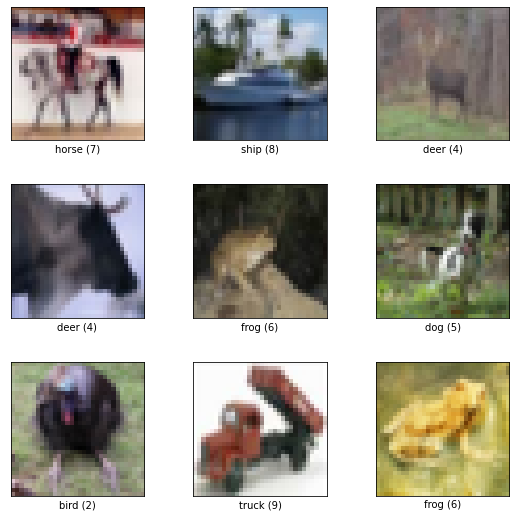

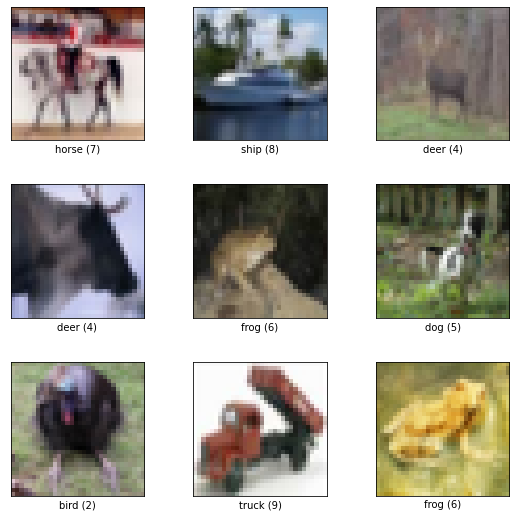

In [126]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
tfds.show_examples(train_ds, info_ds)

In [127]:
print(info_ds)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {

In [128]:
def proccess(data, batch_size, augmentation=None):
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    data = data.map(lambda img, target: ((img/128.)-1., target))
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(batch_size)
    data = data.prefetch(20)

    if augmentation:
        train_ds = train_ds.map(lambda x,y : (augmentation_model(x), y),num_parallel_calls=tf.data.AUTOTUNE)

    return data  #(data.prefetch(tf.data.AUTOTUNE))

In [129]:
train_ds = proccess(train_ds, 32)
val_ds = proccess(test_ds, 32)

### Optimise your model

In [130]:
class ConvModel(tf.keras.Model):

  #1 Constructor
  def __init__(self, L2_reg=0, dropout_rate=0, batch_norm=False):
    super(ConvModel, self).__init__()
    #optimizer, loss function and metrics
    self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
                        tf.keras.metrics.Mean(name="total_frobenius_norm")
                       ]
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss = tf.keras.losses.CategoricalCrossentropy()

    kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None

    self.dropout_rate = dropout_rate
    
    if self.dropout_rate:
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(10, activation='softmax')
    ]

    if batch_norm:
        self.layer_list = [
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(10, activation='softmax')]
            


     # layers to be used
    '''self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax') '''

    #2. call method (forward computation)
  def call(self, x, training=False):
      for layer in self.layer_list[:-1]:
        x = layer(x)
        if self.dropout_rate:
                x = self.dropout_layer(x, training)
      return self.layer_list[-1](x)

  #3. metrics property
  @property
  def metrics(self):
    # return a list with all metrics in the model
    return self.metrics_list


  #4 reset all metrics object
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()

  def compute_frobenius(self):
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables:
        frobenius_norm += tf.norm(var, ord="euclidean")
    return frobenius_norm

  def train_step(self, data):
    img,label = data
    with tf.GradientTape() as tape:
      output = self(img, training=True)
      loss = self.loss(label, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    #update metrics
    self.metrics[0].update_state(values=loss)
    self.metrics[1].update_state(label, output)
    self.metrics[2].update_state(self.compute_frobenius())
    '''for metric in self.metrics[1:]:
      metric.update_state(label, output)'''
    return {m.name : m.result() for m in self.metrics}

  def test_step(self, data):
    img, label = data
    output = self(img, training=False)
    loss = self.loss(label, output)
    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(label, output)
    self.metrics[2].update_state(self.compute_frobenius())
    '''for metric in self.metrics[1:]:
      metric.update_state(label, output)'''
    return {m.name : m.result()  for m in self.metrics}

In [131]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

In [132]:
def visualisation(train_losses, train_acc, test_losses, test_acc):
  plt.figure ()
  line1, = plt.plot(train_losses , "b-" )
  line2, = plt.plot(test_losses , "r-" )
  line3, = plt.plot(train_acc , "b:" )
  line4, = plt.plot(test_acc , "r:" )
  plt.xlabel( " Training steps " )
  plt.ylabel( " Loss / Accuracy " )
  plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
  plt.show()

In [133]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      metrics = model.train_step(data)
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      if key == 'acc':
        train_acc.append(value.numpy())
      if key == 'loss':
        train_loss.append(value.numpy())

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
    
    for (key, value) in metrics.items():
      if key == 'acc':
        val_acc.append(value.numpy())
      if key == 'loss':
        val_loss.append(value.numpy())


    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  model.save_weights(save_path)
  return train_loss, val_loss, train_acc, val_acc

Frobenius norm became too large there it means that over model is prone to overfitting. Therefore the model overfits the data.

We apply optimisation techniques:
1. L2
3. Randomly dropimg units
4. Data augmentation
5. Batch normalization 

**Training model without regularisation**

In [ ]:
#train_ds = proccess(train_ds, batch_size=32)
#val_ds = proccess(val_ds, batch_size=32)


model = ConvModel()
#model(tf.keras.Input((32,32,3)))
#model.summary()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
visualisation(train_loss, train_acc, val_loss, val_acc)


 16%|█▌        | 244/1563 [00:59<05:13,  4.21it/s]

**Training model with L2 regularisation**

In [ ]:
model = ConvModel(L2_reg=0.001)
#model(tf.keras.Input((32,32,3)))
#model.summary()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
visualisation(train_loss, train_acc, val_loss, val_acc)


**Training model with randomly droping units**

In [ ]:
model = ConvModel(dropout_rate=0.5)
#model.summary()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
visualisation(train_loss, train_acc, val_loss, val_acc)


**Training model with batch normalization**

In [ ]:
model = ConvModel(batch_norm=True)
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
visualisation(train_loss, train_acc, val_loss, val_acc)


**Training model with Data augmentation**

In [ ]:
augmentation_model = tf.keras.Sequential([keras_cv.layers.RandAugment(value_range=[0,1],magnitude=0.1)])
train_ds = proccess(train_ds, 32, augmentation_model)
val_ds = proccess(test_ds, 32, augmentation_model)

model = ConvModel(batch_norm=True)
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

train_loss, val_loss, train_acc, val_acc = training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path)
visualisation(train_loss, train_acc, val_loss, val_acc)

